In [1]:
import requests
import zipfile
from pathlib import Path

# Download and extract if needed
stanford_zip = Path("stanford-encyclopedia.zip")
stanford_folder = Path("stanford-encyclopedia")
if not stanford_zip.exists():
    zip_data = requests.get("https://github.com/MNoichl/data-driven-philosophy-GAP2025/raw/refs/heads/main/files/stanford-encyclopedia.zip").content
    with zipfile.ZipFile(zipfile.io.BytesIO(zip_data)) as zip_ref:
        zip_ref.extractall(".")

# Load data
text_data = [open(f, encoding='utf-8').read() for f in stanford_folder.glob("*.md")]
title_data = [f.stem for f in stanford_folder.glob("*.md")]
# Extract year data from copyright strings in the text files
import re

year_data = []
for text in text_data:
    # Look for "Copyright © YYYY" pattern at the beginning of the text
    match = re.search(r'Copyright © (\d{4})', text)  
    if match:
        year_data.append(int(match.group(1)))
    else:
        year_data.append(None)  # If no copyright year found

used_dataset = "Stanford Encyclopedia"

# Named Entity Recognition (NER)

Named entity recognition is a branch of natural language processing (NLP). Within an NLP pipeline, it is a relatively late step:

<center><img src='./files/NER_NLP_pipeline.png' width=700></center>

This is because it needs to receive a tokenized text and, in some languages, it needs to understand a word's part-of-speech (POS) to perform well. To determine whether a particular part of a text is a name, our model relies on a tokenization (splitting) of the text and its tagging for a particular part of speech (noun, verb, etc.). 

*(Graphic from William Mattingly, CC-BY, 2022 Text Analysis Pedagogy Institute)*

In [2]:
!python3 -m spacy download en_core_web_sm # for English NER

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 13.3 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
import spacy

In [4]:
nlp = spacy.load("en_core_web_sm")

/Users/Noich001/Desktop/workbooks_GAP_workshop/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Tokenization distinguishes full stops that end sentences from those that occur in abbreviations and initials (like G. E. Moore) - simply splitting by `.` would not give the right result.

In [5]:
text = "G.E. Moore is known as a good writer. Perhaps he is also good at programming?"

We can run the basic spacy pipeline on our text object like so:

In [6]:
doc = nlp(text)

The resulting doc object is structured. We can inspect its sentences:

In [7]:
list(doc.sents)

[G.E. Moore is known as a good writer.,
 Perhaps he is also good at programming?]

The spacy nlp pipeline also extracts a list of entities. Each entity has a text attribube (from the text source) and a label attribute, which we can inspect:

In [8]:
[(ent.text, ent.label_) for ent in doc.ents]

[('G.E. Moore', 'PERSON')]

This processing of the raw text into a doc object follows a number of steps that we can inspect (and adapt). 

In [9]:
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

## Looking at the Stanford Encyclopedia

Instead of looking at a toy sentence, we can process articles from the Stanford Encyclopedia. Here for a single (arbitrary) article:

In [10]:
doc = nlp(text_data[42])

The NER will now try to detect (and distinguish) persons, organizations, etc. If we only look at the entities tagged as persons:

In [11]:
[(ent.text, ent.label_) for ent in doc.ents if ent.label_=='PERSON'][0:20]

[("John Stuart Mill's", 'PERSON'),
 ('Mill 1859/1975', 'PERSON'),
 ('Schneewind', 'PERSON'),
 ('Wolff', 'PERSON'),
 ('Kant', 'PERSON'),
 ('Crocker 1980', 'PERSON'),
 ('Feinberg', 'PERSON'),
 ('Dworkin 1988', 'PERSON'),
 ('Feinberg', 'PERSON'),
 ('Dworkin 1989', 'PERSON'),
 ('Arneson', 'PERSON'),
 ('Raz 1986', 'PERSON'),
 ('Berofsky 1995', 'PERSON'),
 ('Raz 1986', 'PERSON'),
 ('Berofsky', 'PERSON'),
 ('Berofsky 1995', 'PERSON'),
 ('Veltman', 'PERSON'),
 ('Friedman', 'PERSON'),
 ('Kant', 'PERSON'),
 ('Hill', 'PERSON')]

In [12]:
print(f'We find {len([ent for ent in doc.ents if ent.label_=="PERSON"])} person labelled entities')

We find 79 person labelled entities


We can summarize this with a Counter object:

In [13]:
from collections import Counter
count = Counter()
count.update([ent.text for ent in doc.ents if ent.label_=='PERSON'])
count.most_common(10)

[('Kant', 9),
 ('Korsgaard', 4),
 ('Arneson', 3),
 ('Raz 1986', 3),
 ('Berofsky 1995', 3),
 ('Rawls', 3),
 ('Feinberg', 2),
 ('Benson', 2),
 ('Grovier 1993', 2),
 ('Taylor', 2)]

And clean some of the labels by removing the year-strings - this is also important to sum over variants.

In [14]:
def strip_years(text):
    """
    Clean years and punctuation from labels.
    """
    return re.sub("\s?[0-9]|['|.)(]",'', text)

strip_years("Kant's new add")

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_84127/397326273.py:5: SyntaxWarning: invalid escape sequence '\s'
  return re.sub("\s?[0-9]|['|.)(]",'', text)


'Kants new add'

In [15]:
count = Counter()
count.update([strip_years(ent.text) for ent in doc.ents if ent.label_=='PERSON'])
count.most_common(10)

[('Kant', 9),
 ('Raz', 4),
 ('Berofsky', 4),
 ('Korsgaard', 4),
 ('Rawls', 4),
 ('Arneson', 3),
 ('Benson', 3),
 ('Feinberg', 2),
 ('Dworkin', 2),
 ('Grovier', 2)]

But have all person names been understood correctly? let's look at the Organizations.

In [16]:
count = Counter()
count.update([strip_years(ent.text) for ent in doc.ents if ent.label_=='ORG'])
count.most_common(10)

[('Stoljar', 5),
 ('Benson', 3),
 ('Kymlicka', 3),
 ('MacKenzie & Stoljar', 2),
 ('Christman', 2),
 ('Liberalism', 2),
 ('Cuypers', 1),
 ('MacCallum', 1),
 ('R Young', 1),
 ('Fisher & Ravizza', 1)]

A lot of these organization tags are actually referring to people - unsurprising, since many organizations are named after people. So we should expect some errors when trying to distinguish these automatically. 

In our specific case, we have background knowledge - we expect people to be mentioned much more than companies or organizations. And we know that many of these names are philosophers that should be tagged as persons. To take this into account, we can add an extra step in the NER pipeline.

## Adding an entity ruler

We can add explicit rules for detecting entities with an 'entity ruler'. This acts as an additional step in the spaCy pipeline.

In [17]:
names = ['Stoljar', 'Benson', 'Kymlicka'] # These can be many, feel free to add your own...
patterns = [{"label":"PERSON", "pattern":name} for name in names]

In [18]:
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [19]:
nlp2 = spacy.load("en_core_web_sm", exclude=["tagger","parser","lemmatizer","attribute_ruler"])

In [20]:
entruler = spacy.blank('en') # Create a blank English model
nlp_rules = nlp2.add_pipe("entity_ruler", before='ner') # specify that the EntityRuler comes before built-in NER
nlp_rules.add_patterns(patterns)

In [21]:
nlp2.pipe_names

['tok2vec', 'entity_ruler', 'ner']

The entity ruler now tags the patterns we have defined as persons, before we run the standard NER component. 

In [22]:
doc2 = nlp2(text_data[42])

In [23]:
count2 = Counter()
count2.update([strip_years(ent.text) for ent in doc2.ents if ent.label_=='PERSON'])
count2.most_common(10)

[('Kant', 9),
 ('Stoljar', 8),
 ('Benson', 7),
 ('Kymlicka', 7),
 ('Raz', 4),
 ('Berofsky', 4),
 ('Korsgaard', 4),
 ('Rawls', 4),
 ('Arneson', 3),
 ('Feinberg', 2)]

Compare again with the top names without our entity ruler:

In [24]:
doc = nlp(text_data[42])
count = Counter()
count.update([strip_years(ent.text) for ent in doc.ents if ent.label_=='PERSON'])
count.most_common(10)

[('Kant', 9),
 ('Raz', 4),
 ('Berofsky', 4),
 ('Korsgaard', 4),
 ('Rawls', 4),
 ('Arneson', 3),
 ('Benson', 3),
 ('Feinberg', 2),
 ('Dworkin', 2),
 ('Grovier', 2)]

Now the explicitly mentioned names are taken into account. Of course, in the raw text there are many more phrases and words that we might want to include as mentions of e.g. Kant:

In [25]:
c = Counter()
c.update([strip_years(word) for word in text_data[42].split(' ') if re.match('Kant', word)])

In [26]:
c

Counter({'Kantian': 12,
         'Kant': 5,
         'Kant,': 3,
         'Kants': 2,
         'Kantians': 1,
         'Kantianism': 1})

Is 'Kant' mentioned when Korsgaard is described as a Kantian? Even simple counting needs to answer some conceptual questions.

## Running on the full corpus
(not efficient, can take a while...) Here we are only taking the first 10

In [27]:
from tqdm import tqdm
import os

docs = list(
    tqdm(
        nlp2.pipe(text_data, batch_size=1, n_process=max(os.cpu_count()-1, 1)),
        total=len(text_data),
        unit="doc",
        mininterval=0.2
    ))

100%|██████████| 1430/1430 [05:41<00:00,  4.19doc/s]


In [28]:
corpcount = Counter()
for doc in docs:
    corpcount.update([strip_years(ent.text) for ent in doc.ents if ent.label_=='PERSON'])

In [29]:
corpcount.most_common()

[('Kant', 5757),
 ('Aristotle', 2690),
 ('Russell', 2478),
 ('Plato', 2120),
 ('Lewis', 1619),
 ('Mill', 1532),
 ('Heidegger', 1423),
 ('Hegel', 1301),
 ('John', 1135),
 ('Cohen', 906),
 ('Rawls', 897),
 ('Augustine', 884),
 ('Davidson', 842),
 ('Einstein', 822),
 ('Gödel', 756),
 ('Marx', 726),
 ('Brentano', 713),
 ('Hilbert', 693),
 ('Reid', 664),
 ('Moore', 648),
 ('Ortega', 634),
 ('Darwin', 626),
 ('James', 617),
 ('Williams', 591),
 ('Ockham', 590),
 ('Aquinas', 578),
 ('Thomas', 536),
 ('Hobbes', 520),
 ('Anderson', 506),
 ('Albert', 500),
 ('Weyl', 495),
 ('Reichenbach', 487),
 ('Austin', 482),
 ('Wolff', 479),
 ('Avicenna', 476),
 ('Alexander', 462),
 ('Tarski', 460),
 ('Jones', 433),
 ('Smith', 430),
 ('Wright', 423),
 ('Frege', 415),
 ('Maimonides', 412),
 ('Jacobi', 406),
 ('Rousseau', 390),
 ('Fichte', 388),
 ('Mary', 383),
 ('Confucius', 375),
 ('Mach', 369),
 ('Kant’s', 360),
 ('Parmenides', 353),
 ('Burke', 352),
 ('Dasein', 351),
 ('Chisholm', 346),
 ('Kierkegaard', 34

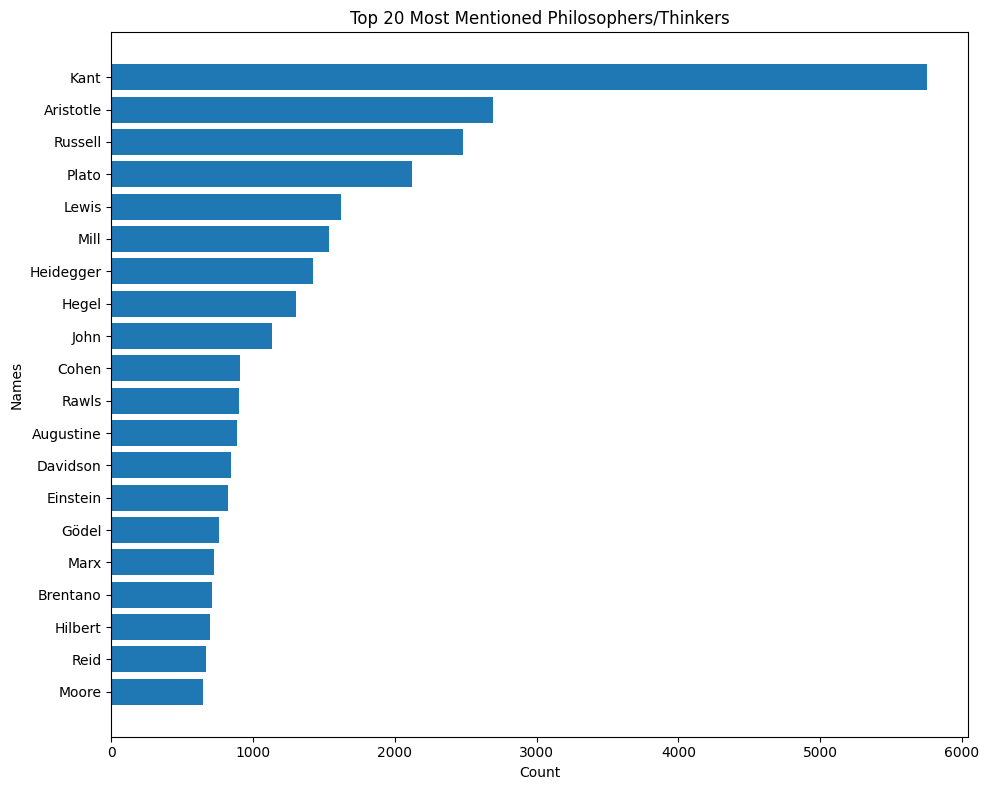

In [30]:
import matplotlib.pyplot as plt

# Get top 20 most common names
top_20 = corpcount.most_common(20)
names = [item[0] for item in top_20]
counts = [item[1] for item in top_20]

# Create horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(names, counts)
plt.xlabel('Count')
plt.ylabel('Names')
plt.title('Top 20 Most Mentioned Philosophers/Thinkers')
plt.gca().invert_yaxis()  # To show highest count at top
plt.tight_layout()
plt.show()
